In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import Mapping
import os
import numpy as np

/tmp/ipykernel_9001/89854707.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


The 18 identifiers that make health information PHI are:

 - Names
 - Dates, except year
 - Telephone numbers
 - Geographic data
 - FAX numbers
 - Social Security numbers
 - Email addresses
 - Medical record numbers
 - Account numbers
 - Health plan beneficiary numbers
 - Certificate/license numbers
 - Vehicle identifiers and serial numbers including license plates
 - Web URLs
 - Device identifiers and serial numbers
 - Internet protocol addresses
 - Full face photos and comparable images
 - Biometric identifiers (i.e. retinal scan, fingerprints)
 - Any unique identifying number or code

In [2]:
deid_dict = {
    "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"],
    "name": ["fore_name", "surname","initials"],
    "contact_details": ["address", "telephone_number", "email", "identification","url"],
    "address": ["address_line", "postcode"],
    "identification": ["passport_number", "driving_licence_number","national_insurance"],
    "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number", "lab_number","gmc_number"],
    "date": ["date_of_birth"]
    }


In [3]:
print(deid_dict.keys())


dict_keys(['de-identification_root_concept', 'name', 'contact_details', 'address', 'identification', 'healthcare_identifier', 'date'])


#### Meta_annotations will hold the contextual information of the concept.
"Subject": ["Patient", "Relative", "Healthcare provider"] (unselected meta_ann will mean "other/ N/A")


In [4]:
deid_cui_dict = {
"de-identification root concept": "r0000",
"name": "n1000",
"fore name": "n1100",
"surname": "n1200",
"initials":"n1300",
"contact details": "c2000",
"address": "c2100",
"address line": "c2110",
"postcode": "c2120",
"telephone number":"c2200",
"email": "c2300",
"identification": "c2400",
"passport number": "c2410",
"driving licence_number": "c2420",
"national insurance": "c2430",
"healthcare identifier": "h3000",
"nhs number": "h3100",
"hospital number": "h3200",
"emergency department_number": "h3300",
"lab number": "h3400",
"gmc number":"h3500",
"date": "d4000",
"date of birth": "h4100"
}


In [5]:
len(deid_cui_dict)

23

In [6]:
deid_dict = {
    "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"],
    "name": ["fore_name", "surname","initials"],
    "contact_details": ["address", "telephone_number", "email", "identification","url"],
    "address": ["address_line", "postcode"],
    "identification": ["passport_number", "driving_licence_number","national_insurance"],
    "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number", "lab_number","gmc_number"],
    "date": ["date_of_birth"]
    }

In [14]:
# q

In [7]:
deid_fig = {
    "de-identification root concept": {
        "name": {
            "fore name": 1100,
            "surname": 1200,
            "initials":1300},
        "contact details": {
            "address": {
                "address line": 2110,
                "postcode": 2120},
            "telephone number": 2200,
            "email": 2300,
            "identification \n number": {
                "passport": 2410,
                "driving licence": 2420,
                "national insurance": 2430}},
        "healthcare identifier": {
            "nhs \n number": 3100,
            "hospital \n number": 3200,
            "emergency \n department number": 3300,
            "lab number": 3400,
            "gmc number": 3500},
        "date": {
            "date of birth": 4100}
    }}

# Visualisation of temininology

In [8]:
G = nx.DiGraph()


In [10]:
q = list(deid_fig.items())
while q:
    v, d = q.pop()
    for nv, nd in d.items():
        G.add_edge(v, nv)
        if isinstance(nd, Mapping):
            q.append((nv, nd))
            
np.random.seed(42)


In [11]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})


In [12]:
pos = hierarchy_pos(G, 'de-identification root concept')

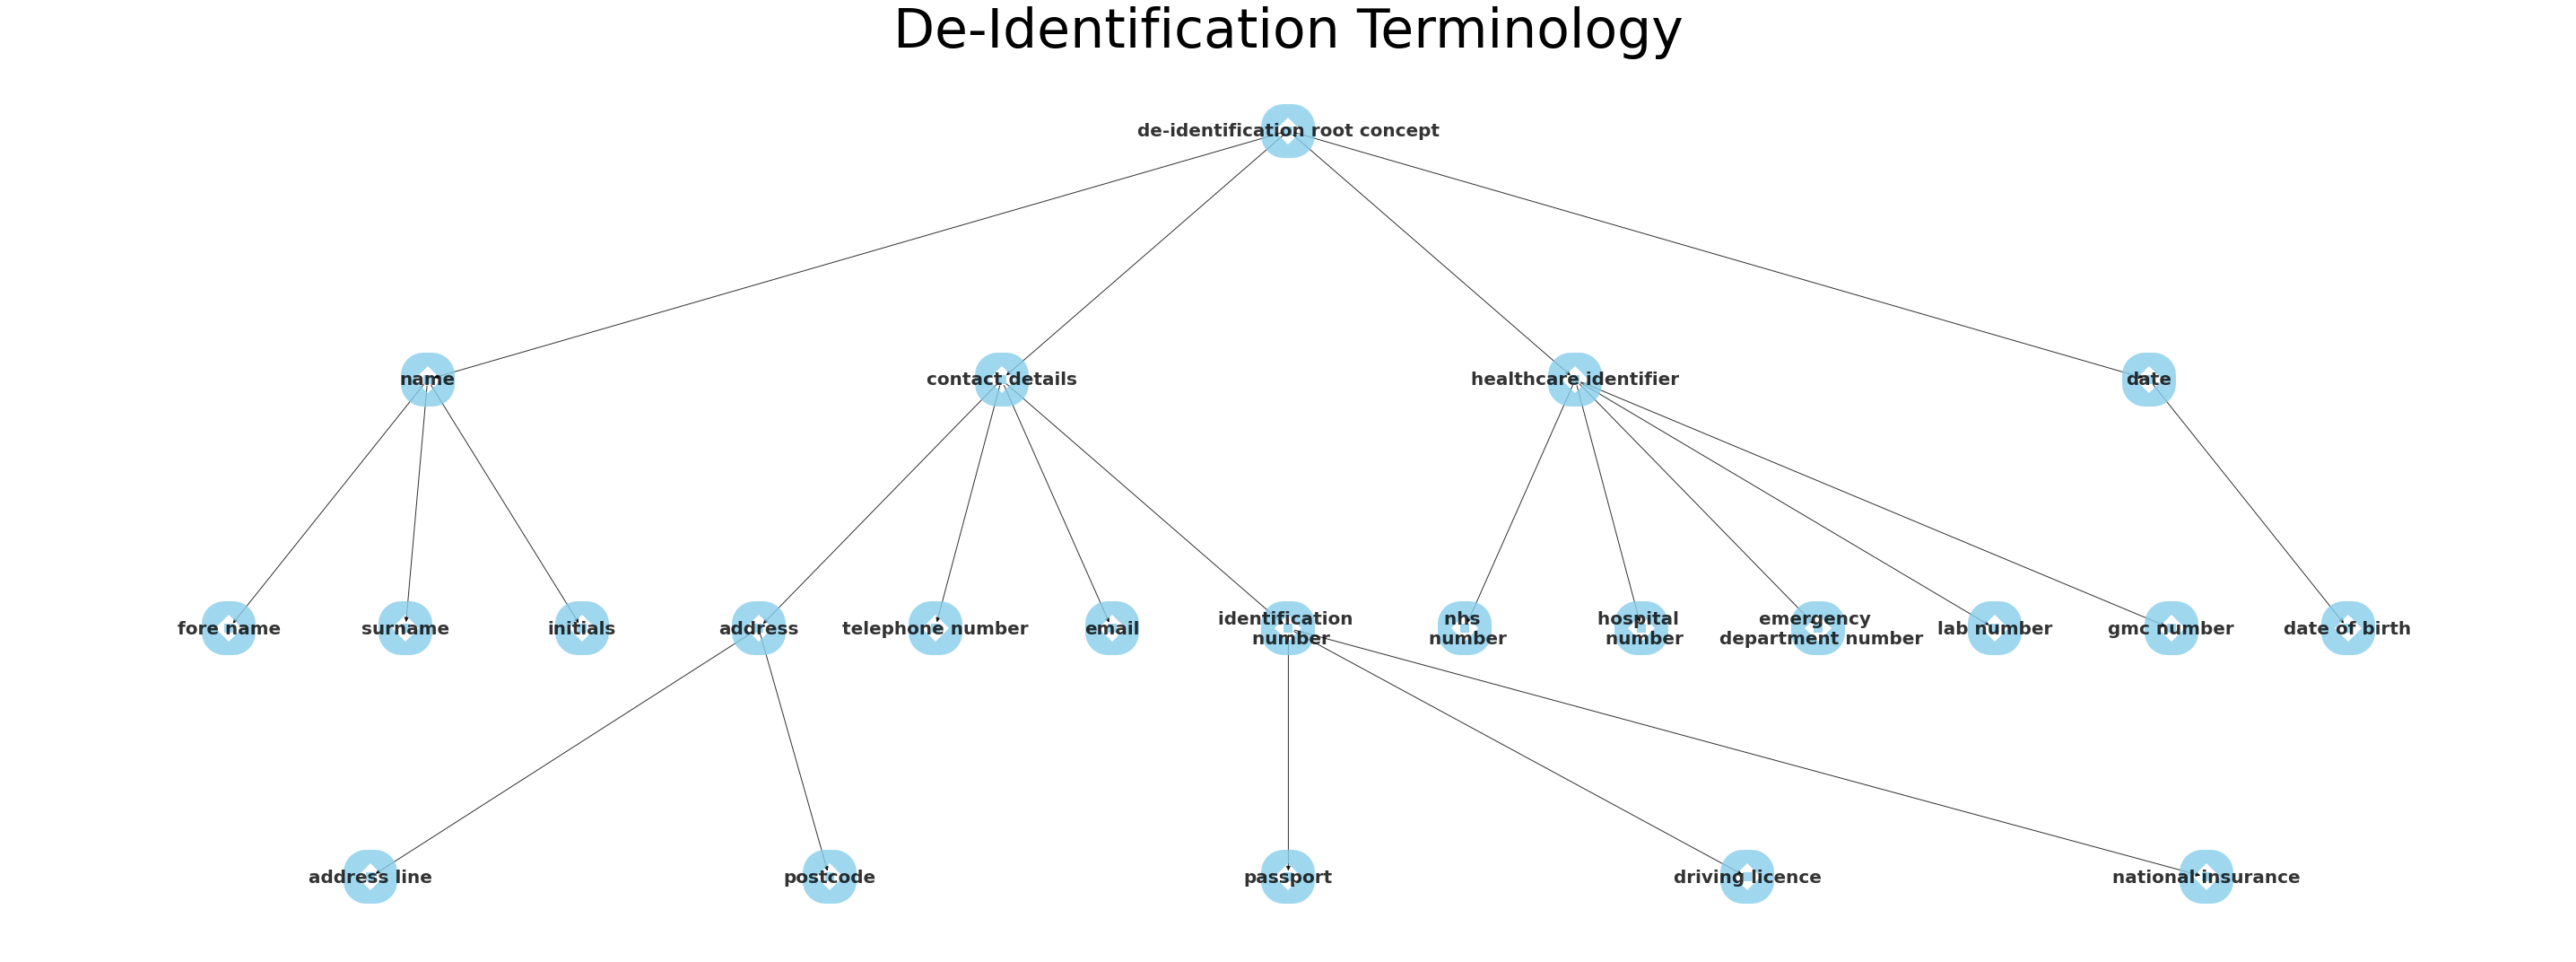

In [13]:
plt.figure(3, figsize=(40,15))
plt.title("De-Identification Terminology", fontsize=60)
nx.draw(G, pos=pos, with_labels=True, node_size=100,font_size=20,font_weight="bold", node_color="skyblue", node_shape="s", alpha=0.8, linewidths=50)
plt.tight_layout()
plt.savefig("DeID_teminology.png")


In [21]:
# TODO: Review and delete this section if not necessary


# https://python-graph-gallery.com/321-custom-networkx-graph-appearance/
print(os.getcwd())
df_diagram = pd.read_csv("cbd_diagram.csv")
print(df_diagram)
# Build your graph
G=nx.from_pandas_edgelist(df_diagram, 'from', 'to')#, edge_attr=True)
 
# Graph with Custom nodes:
plt.figure(figsize=(8,8)) 
nx.draw(G, with_labels=True, node_size=60,font_size=8, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
pos=nx.spring_layout(G)
plt.show()

/home/jonny/Documents/Medcat/MedCAT_Deidentification/Creating_a_de-identification_terminology


FileNotFoundError: [Errno 2] No such file or directory: 'cbd_diagram.csv'

In [6]:
# TODO: Create a JSON file with the terminology structure with only the Fully specified names (FSN)
deid_json = json.dumps(deid_dict, sort_keys=True)
print(deid_json)


# TODO: create a CUI convention which reflects terminology structure
# code consists of 2 parts a letter = the term it belongs to (either the root, or the 1st child term) then a 4 letter code linking the term into the rest of the dictionary [first_parent][second parent][third parent][fourth parent]
deid_cui_dict = {
    "de-identification_root_concept": "r0000",
    "name": "n1000",
    "contact_details": "c2000",
    "healthcare_identifier": "h3000",
    "date": "d4000",
    "fore_name": "n1100",
    "surname": "n1200",
    "initials":"n1300",
    "address": "c2100",
    "address_line": "c2110",
    "postcode": "c2120",
    "telephone_number":"c2200",
    "email": "c2300",
    "identification": "c2400",
    "passport_number": "c2410",
    "driving_licence_number": "c2420",
    "national_insurance": "c2430",
    "nhs_number": "h3100",
    "hospital_number": "h3200",
    "emergency_department_number": "h3300",
    "lab_number": "h3400",
    "gmc_number":"h3500",
    "date_of_birth": "h4100",
    "url": "c2500"
    }

{"address": ["address_line", "postcode"], "contact_details": ["address", "telephone_number", "email", "identification", "url"], "date": ["date_of_birth"], "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"], "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number", "lab_number", "gmc_number"], "identification": ["passport_number", "driving_licence_number", "national_insurance"], "name": ["fore_name", "surname", "initials"], "website": ["URL"]}


# Create a CDB CSV format file following the structure:

|cui|str|onto|tty|tui|sty|desc|
|--|--|--|--|--|--|--|

__cui__ - The concept unique identifier, this is simply an ID in your database

__str__ - String/Name of that concept. It is important to write all possible names and abbreviations for a concept of interest.

__onto__ - Source ontology, e.g. HPO, SNOMED, HPC,...

__tty__ - Term type e.g. PN - Primary Name. Primary names are important and I would always recommend to add this fields when creating your CDB. Important to distinguish from synoymns. 

__tui__ - Semantic type identifier - A unique identifier code for each semantic type.

__sty__ - Semantic type - AKA fully specified name of top level concept group

__desc__ - Description of this concept


In [7]:
# TODO: enrich the terminology with synonyms
# TODO: Create a csv file with each concept and concept unique identifier

# dictionary of root concepts for the de-id cui database

# dictionary of descriptions for the de-id cui database
deid_desc = {
    "de-identification_root_concept": "root concept of de-identification",
    "name": "surname and forename",
    "contact_details": "non hospital identification and contact details",
    "healthcare_identifier": "hospital derived ID",
    "date": "personal dates",
    "fore_name": "given name including middle names (each name, e.g. first and middle name, is treated as a separate concept)",
    "surname": "all surnames",
    "initials": "all initials (initials that aren't seperated by a space are treated as a single concept, e.g. EJ)",
    "address": "address and postcode (including a comma or full stop at the end of the address string)",
    "address_line": "all address line items including city and country",
    "postcode": "all postcodes",
    "telephone_number":"telephone numbers both mobile and landline",
    "email": "email addresses",
    "identification": "non hospital identification",
    "passport_number": "passport number",
    "driving_licence_number": "driving licence",
    "url":"all websites associated with an individual",
    "national_insurance": "all national insurance numbers",
    "nhs_number": "nhs numbers",
    "hospital_number": "hospital number from kings college hospital and other trusts",
    "emergency_department_number": "number given by kings college hospital emergency number",
    "lab_number":"all lab ids used to identify samples",
    "gmc_number":"General Medical Council (GMC) number",
    "date_of_birth": "date of birth"
    }

In [15]:
df = pd.DataFrame(deid_cui_dict.items(), columns=['str', 'cui'])
df["onto"] = "cat_anon"
df["tty"] ="PN"
df["tui"] = ""
df["sty"] = ""
#sty_df = d.DataFrame(deid_sty.items(), columns=['str', 'desc'])
desc_df = pd.DataFrame(deid_desc.items(), columns=['str', 'desc'])
#df = df.merge(sty_df, left_on="str",right_on="str")
df = df.merge(desc_df, left_on="str",right_on="str")
df['cui'] = df['cui'].str.upper()
print(df)

                               str    cui      onto tty tui sty  \
0   de-identification_root_concept  R0000  cat_anon  PN           
1                             name  N1000  cat_anon  PN           
2                  contact_details  C2000  cat_anon  PN           
3            healthcare_identifier  H3000  cat_anon  PN           
4                             date  D4000  cat_anon  PN           
5                        fore_name  N1100  cat_anon  PN           
6                          surname  N1200  cat_anon  PN           
7                         initials  N1300  cat_anon  PN           
8                          address  C2100  cat_anon  PN           
9                     address_line  C2110  cat_anon  PN           
10                        postcode  C2120  cat_anon  PN           
11                telephone_number  C2200  cat_anon  PN           
12                           email  C2300  cat_anon  PN           
13                  identification  C2400  cat_anon  PN       

In [16]:
# Note: it was decided not to use any synthesised numbers or names extracted from onlie websites (there were issues with spaces)
df.to_csv("./cui_05082021.csv", index=False)

In [30]:
# read in list
def read_list(name, encode):
    with open(name, encoding = encode) as file:
        lines = [line.rstrip('\n') for line in file]
        return lines

In [31]:
# read in list of first names
def list_2_df(lst,cui, sty):
    """
    Takes a list of words, the cui (concept) and sty (root concept) nad turns this into a cat_anon dataframe
    """
    temp_df = pd.DataFrame({'str':lst})
    temp_df["cui"] = cui
    temp_df["onto"] = "cat_anon"
    temp_df["tty"] ="SN"
    temp_df["tui"] = ""
    temp_df["sty"] = ""
    temp_df["desc"] = ""
    return temp_df

In [28]:
first_names = read_list("cleaned_output/cleaned_first_name.txt","UTF-8")
last_names = read_list("cleaned_output/cleaned_last_name.txt","UTF-8")
hosp_num = read_list("cleaned_output/cleaned_last_name.txt","UTF-8")
nhs_num = read_list("cleaned_output/nhs_numbers.txt","UTF-8")
postcodes = read_list("cleaned_output/postcodes.txt","UTF-8")

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_output/cleaned_first_name.txt'

In [ ]:
first_df = list_2_df(first_names, "n1100", "")
last_df = list_2_df(last_names, "n1200", "")
hosp_df = list_2_df(hosp_num, "h3200", "")
nhs_df = list_2_df(nhs_num, "h3100", "")
postcode_df = list_2_df(postcodes, "c2120", "")
print(postcode_df.head())

In [ ]:
#output broken up for to make files smaller
df_list1 = [df, first_df, last_df]
df_list2 = [hosp_df, postcode_df]
df_list3 = [nhs_df]
#df_list4 = [landline_df, mobile_df]
output_df1 = pd.concat(df_list1)
output_df2 = pd.concat(df_list2)
output_df3 = pd.concat(df_list3)
#output_df4 = pd.concat(df_list4)


In [ ]:
output_df1.to_csv("cui1.csv", index=False)
output_df2.to_csv("cui2.csv", index=False)
output_df3.to_csv("cui3.csv", index=False)
#output_df4.to_csv("cui4.csv", index=False)

In [ ]:
# full output
df_list = [df, first_df, last_df,hosp_df, postcode_df,nhs_df]
full_output = pd.concat(df_list)
output_fill=full_output.to_csv("full_cui_medcat040221.csv", index=False)